# Analysis of the weatherStation data
In this notebook we use some basic time series tools to analyze a dataset of temperatures and humidity from the Otaniemi area. The measurements are taken from a timeperiod of one week (21.11.2018 - 28.11.2018), where a measurement is taken once per hour. 

This project is part my full stack data analysis project. More information can be found from Github:

https://github.com/JoonasMaanonen/weatherStation

**Note: Im still learning time series analysis so you should take my words with a grain of salt.**

## Imports and Options

In [1]:
PATH = "udpServer/server/"

In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Original Timeseries
It is always good idea to first plot the original series before doing any more analysis. 

The temperature time series has a slight downwards trend and the humidity time series has slight upwards trend. This indicates that temperature and humidity are negatively correlated. 

The plots also indicate that there might be some deterministic seasonality with some period length. A logical assumption would be that the period length is 24 hours, since we are talking about weather measurements.

In [4]:
def plot_time_series(df, fld1, fld2, title, ylabel):
    fig, ax = plt.subplots()
    ax.plot(df[fld1], df[fld2])

    # Rotate and align the tick labels.
    fig.autofmt_xdate()

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid()

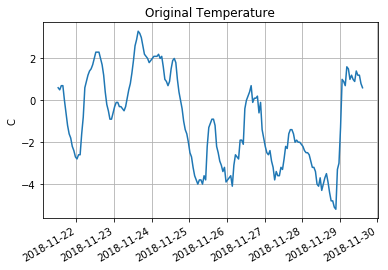

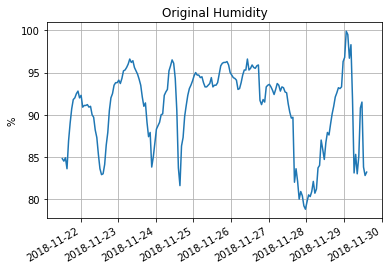

In [5]:
df_raw = pd.read_csv(f"{PATH}measurements.csv", low_memory=False,
                   parse_dates=["Date"])

df_temp = df_raw[["Date", "Temperature(C)"]]
df_hum = df_raw[["Date", "Humidity(%)"]]

plot_time_series(df_temp, "Date", "Temperature(C)", "Original Temperature", "C")
plot_time_series(df_hum, "Date", "Humidity(%)", "Original Humidity", "%")

## Stationarity
In order for our standard time series models (SARIMA) to work. Our series has to be stationary. It means that all of our measurements come from the same distribution. In more concrete terms the series needs to satisfy three conditions:

**(i)** The expected value does not depend on time:
    $$ E(x_t) = \mu, \; \; \text{for all}\ t \in T $$

**(ii)** The variance is finite and does not depend on time:
    $$ var(x_t) = \sigma² < \infty, \; \; \text{for all}\ t \in T $$ 
    
**(iii)** The covariance of $x_t$ and $x_s$ does not depend on the time points t and s. It only depends on the difference of t and s:
    $$ cov(x_t, x_s) = \gamma_{t-s}, \; \; \text{for all}\ t \in T$$


These conditions imply that when we look at a realization of a stationary stochastic process we should not detect:

**1.** Trend

**2.** Systematic changes in variance

**3.** Deterministic seasonality


Our series does have some trend component and seasonality. Therefore we need to stationarize the series before applying any of the time series analysis methods to it.

## Removing trends from time series
Differencing is a technique that can be used to remove trends or seasonal components from a time series.

The difference operator is defined as:

$$ Dx_t = x_t - x_{t-1} $$

This operator can be used to remove a linear trend from the data.
We can get the original series back by adding the substracted values back to the diffed series:

$$ x_t = Dx_t + x_{t-1} $$

We can see this in action from the plots below. Note that there seems to some small difference between the original temp data and the inverted temp data. This is due to the numerical accuracy of our differencing being much higher than my original measument data. We can tackle this problem later, if it becomes and issue.

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Computes that difference
def difference(data, lag=1):
    diffed_data = []
    # Can't invert the first 0 - lag terms, so just add them to series, so we don't lose observations. 
    for i in range(0, lag):
        diffed_data.append(data[i])
        
    for t in range(lag, len(data)):
        value = data[t] - data[t - lag]
        diffed_data.append(value)
    return diffed_data

def invert_difference(diffed_data, orig_data, lag=1):
    inverted_data = []
    
    for i in range(0, lag):
        inverted_data.append(diffed_data[i])
    
    for t in range(lag, len(diffed_data)):
        value = diffed_data[t] + orig_data[t - lag]
        inverted_data.append(value)
    return inverted_data

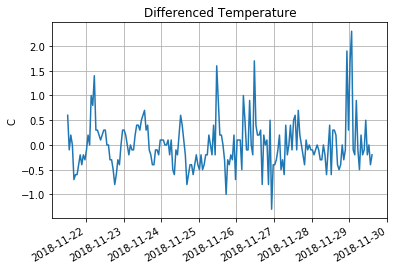

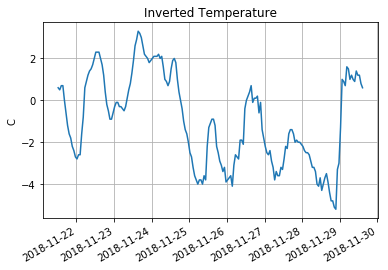

In [8]:
# Take first order difference to remove linear trend
diff_temp = difference(df_temp["Temperature(C)"])

# Bit hackish, maybe there's a better way to do this
df_date = df_raw[["Date"]]
df_diff_temp = df_date
df_diff_temp["Temperature(C)"] = diff_temp
plot_time_series(df_diff_temp, "Date", "Temperature(C)", "Differenced Temperature", "C")

# Invert that difference and see if we get back the same series 
inverted_temp = invert_difference(diff_temp, df_temp["Temperature(C)"])
df_inverted_temp = df_date
df_inverted_temp["Temperature(C)"] = inverted_temp

# Let's compare to the original data
plot_time_series(df_inverted_temp, "Date", "Temperature(C)", "Inverted Temperature", "C")

## Removing Seasonality from a time series
We can use differencing to remove seasonal components from our time series aswell. We set our difference period to be our season length: 

$$ D_{24}x_t = x_t - x_{t-24} $$



We also have to preprocess our data to be dividable by our season lenght or else we will lose some of the series by differencing it by the season length.

From looking at the differenced series below we can quite confidently say that it is now stationary. Therefore let's now start using some time series models to model this data.

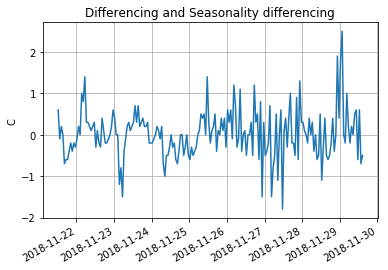

In [9]:
 # DD24
final_temp = difference(diff_temp, lag=24)
df_final_temp = df_date
df_final_temp["Temperature(C)"] = final_temp

plot_time_series(df_final_temp, "Date", "Temperature(C)", "Differencing and Seasonality differencing", "C")

## Autocorrelation plots
Good tools for determining, which time series might fit the data well are the autocorrelation and partial autocorrelation plots. In hindsight these might have been good to plot before doing differencing aswell.

### Original data

In [10]:
#from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
# This is needed for plot_acf to work for some reason
def convert_to_datetime(df, fld):
    datetime = pd.to_datetime(df_temp[fld])
    df['datetime'] = datetime
    df = df.set_index('datetime')
    df.drop(['Date'], axis=1, inplace=True)
    return df
    

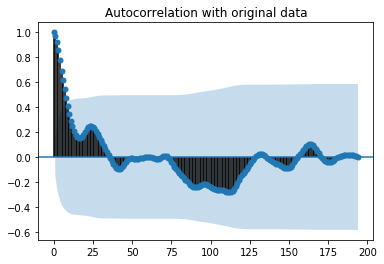

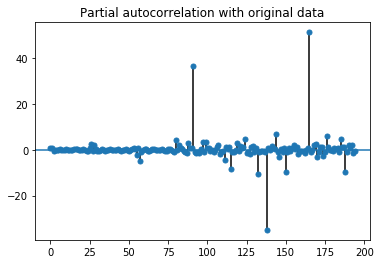

In [12]:
df_temp2 = convert_to_datetime(df_temp, "Date")

_ = plot_acf(df_temp2, title="Autocorrelation with original data") # Return value to remove duplicate plot
_ = plot_pacf(df_temp2, title="Partial autocorrelation with original data") # Return value to remove duplicate plot

### Final Data
We can see from the autocorrelation plots that they're not perfect, but much better than in the undiffed case. The partial autocorrelation plot in particular does not have seasonal peaks anymore. Since autocorrelation plot has some exponential decay, let's try basic AR plot first. It's very logical that current temperature would depend on the previous temperature, therefore this should work atleast decently

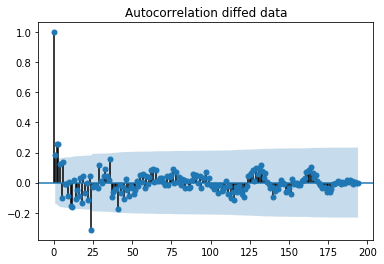

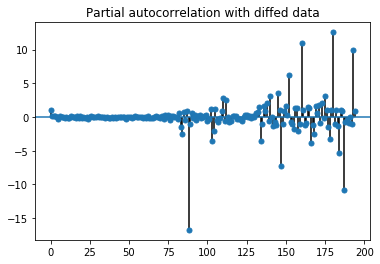

In [13]:
final_df = convert_to_datetime(df_final_temp, "Date")
_ = plot_acf(final_df, title="Autocorrelation diffed data")
_ = plot_pacf(final_df, title="Partial autocorrelation with diffed data")

## AR(p) process
Autoregressive process is defined as:
$$ x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + \epsilon_t, \; \; (\epsilon_t)_{t \in T} \sim WN(0, \sigma^2)$$

The intuitive understanding is that the future temperature depends on the past temperatures and some error term. 

Let's start by trying AR(1) process:
$$ x_t = \phi_1 x_{t-1} + \epsilon_t $$

In [14]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


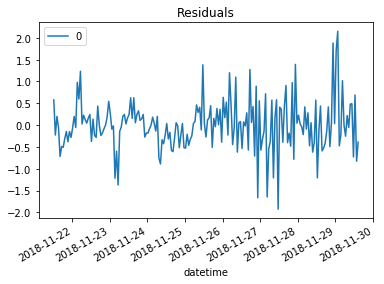

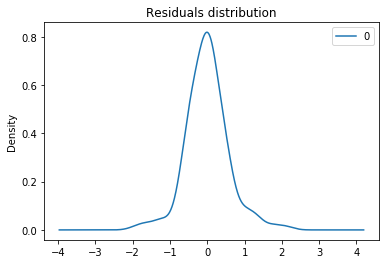

In [15]:
model = ARMA(final_df, order=(1, 0))
model_fit = model.fit(disp=0)
#print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
_ = residuals.plot(kind="kde", title="Residuals distribution")
#print(residuals.describe())

## Using the model to predict temperature
In order to test whether our model is any good we need to split the data into training and test sets. We use the train set to train the model parameters and then predict the temperature with this trained model. Then we can compare these values to the real values that are in the test set.

The below plot shows our prediction vs the actual measurement data. The prediction is surprisingly good, considering the fact that changes in air pressure, affect the temperature drastically and our model does not take these changes into account.

The second plot shows a fundamental principle in modeling. When we predict too far into to future our prediction will be the mean of our series. Which in AR(1) model, which assumes stationarity, is: $ E[x_t] = 0 $. This is very intuitive, since AR(1) model is based on the previous measurements, which contain very little information about the temperature 30 hours to the future.

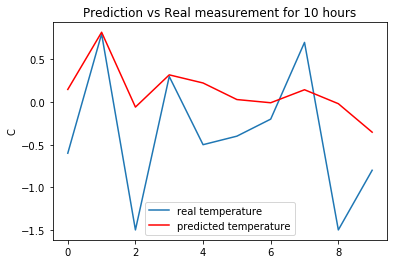

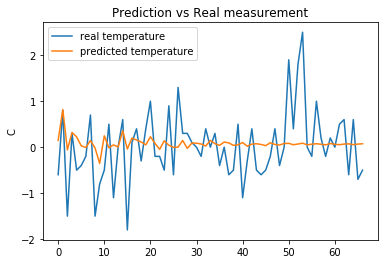

In [16]:
split = int(len(df_temp) * 0.66)
train, test = df_final_temp[0:split], final_df[split:len(final_df)]
pure_train, pure_test = train["Temperature(C)"].values, test["Temperature(C)"].values

model = AR(pure_train)
model_fit = model.fit()
predictions = model_fit.predict(start = len(pure_train), end=len(pure_train) + len(pure_test) - 1, dynamic=False)
plt.figure(1)
plt.plot(pure_test[0:10])
plt.plot(predictions[0:10], color="red")
plt.ylabel("C")
plt.title("Prediction vs Real measurement for 10 hours")
_ = plt.legend(["real temperature", "predicted temperature"])

plt.figure(2)
plt.plot(pure_test)
plt.plot(predictions)
plt.ylabel("C")
plt.title("Prediction vs Real measurement")
_ = plt.legend(["real temperature", "predicted temperature"])

